#  Install and Import all necessary libraries


In [17]:
# --- Install necessary libraries (run once) ---
!pip install -q opencv-python-headless matplotlib numpy pandas scikit-learn seaborn
!pip install -q torch torchvision torchaudio
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q tqdm

# --- Import all necessary libraries ---

# Basic
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Image Processing
import cv2
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Segmentation Models (like Unet, FPN, etc.)
import segmentation_models_pytorch as smp

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm import tqdm
import time
import shutil
import glob
from IPython.display import display
from google.colab import files

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("✅ All libraries installed and imported successfully.")


✅ All libraries installed and imported successfully.


# Load the Rim Segmentation Model

In [2]:
import os
import urllib.request
import torch
import segmentation_models_pytorch as smp

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_URL = "https://github.com/HeetSavaliya/Toilet-Rim-Segmentation-Model/raw/main/rim_segmentation_model_finetuned.pth"
MODEL_PATH = "rim_segmentation_model_finetuned.pth"

# Download model if not present
if not os.path.exists(MODEL_PATH):
    print("Downloading model...")
    urllib.request.urlretrieve(MODEL_URL, MODEL_PATH)
    print("Model downloaded.")

# Initialize model architecture
model = smp.Unet('resnet18', encoder_weights='imagenet', in_channels=3, classes=1)

# Load weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


Model downloaded.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Define all the Functions to be used later

In [3]:
import torch
import cv2
import numpy as np
from torchvision import transforms

# Adjust based on your model's input
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_SIZE = (256, 256)  # Change to match model input size

# Define transform
# For inference only (no mask needed)
def preprocess(image, target_size=(256, 256)):
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image).permute(2, 0, 1)
    return image


def predict_mask(image):
    model.eval()

    orig_h, orig_w = image.shape[:2]

    # Preprocess
    processed = preprocess(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(processed)

        if output.shape[1] == 1:
            # Binary mask
            mask = torch.sigmoid(output).squeeze().cpu().numpy()
            mask = (mask > 0.5).astype(np.uint8)
        else:
            # Multi-class
            mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy().astype(np.uint8)

    # Resize back to original size
    mask_resized = cv2.resize(mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

    return mask_resized


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def midpoint(p1, p2):
    return ((p1[0] + p2[0]) // 2, (p1[1] + p2[1]) // 2)

def find_last_mask_pixel_along_line(mask, start, end):
    """
    Find last pixel inside mask along line from start to end (inclusive).
    Returns (x,y) of last pixel or None if none found.
    """
    start = np.array(start, dtype=np.float32)
    end = np.array(end, dtype=np.float32)
    line_vec = end - start
    line_len = np.linalg.norm(line_vec)
    if line_len == 0:
        return None
    direction = line_vec / line_len

    last_pixel = None
    for dist in np.linspace(0, line_len, int(line_len)+1):
        point = start + dist * direction
        x, y = int(round(point[0])), int(round(point[1]))
        if 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1]:
            if mask[y, x] > 0:
                last_pixel = (x, y)
            else:
                # hit background, stop searching
                if last_pixel is not None:
                    break
        else:
            break
    if last_pixel == None:
        last_pixel = (int(round(end[0])), int(round(end[1])))
    return last_pixel

def analyze_rect_and_extend(image, mask, draw_labels=True):
    image_copy = image.copy()
    mask = (mask > 0).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        print("No contours found!")
        return {}

    # Sort contours by area descending
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # For 1 contour: just outer
    # For 2 or more: outer and inner (next biggest)
    outer_contour = contours[0]
    inner_contour = contours[1] if len(contours) > 1 else None

    results = {}

    def process_contour(name, cnt, color):
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.intp(box)

        # Calculate contour centroid (center of mass)
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            # fallback to rect center if zero moments
            cx, cy = int(rect[0][0]), int(rect[0][1])
        center = (cx, cy)

        # Draw rotated rectangle and centroid
        cv2.drawContours(image_copy, [box], 0, color, 2)
        cv2.circle(image_copy, center, 12, color, -1)

        # Order points by y, then x
        box = sorted(box, key=lambda p: (p[1], p[0]))
        top_pts = sorted(box[:2], key=lambda p: p[0])   # top-left, top-right
        bottom_pts = sorted(box[2:], key=lambda p: p[0]) # bottom-left, bottom-right
        right_pts = sorted([top_pts[1], bottom_pts[1]], key=lambda p: p[1])  # right edge points

        bottom_mid = midpoint(bottom_pts[0], bottom_pts[1])
        right_mid = midpoint(right_pts[0], right_pts[1])

        # Find last mask pixels along center->bottom_mid and center->right_mid lines
        bottom_last = find_last_mask_pixel_along_line(mask, center, bottom_mid)
        right_last = find_last_mask_pixel_along_line(mask, center, right_mid)

        # Draw midpoints and last pixels (bigger circles)
        cv2.circle(image_copy, bottom_mid, 10, color, -1)
        cv2.circle(image_copy, right_mid, 10, color, -1)

        if bottom_last is not None:
            cv2.circle(image_copy, bottom_last, 14, (0, 255, 255), -1)  # yellow for last pixel bottom
        if right_last is not None:
            cv2.circle(image_copy, right_last, 14, (0, 255, 255), -1)   # yellow for last pixel right

        # Calculate distances (Euclidean)
        dist_bottom = np.linalg.norm(np.array(center) - np.array(bottom_last)) if bottom_last else 0
        dist_right = np.linalg.norm(np.array(center) - np.array(right_last)) if right_last else 0

        print(f"{name.capitalize()} Center: {center}")
        print(f"→ Distance to Last Bottom Pixel: {dist_bottom:.2f}")
        print(f"→ Distance to Last Right Pixel:  {dist_right:.2f}\n")

        results[name] = {
            "center": center,
            "bottom_midpoint": bottom_mid,
            "right_midpoint": right_mid,
            "last_bottom_pixel": bottom_last,
            "last_right_pixel": right_last,
            "distance_to_last_bottom": dist_bottom,
            "distance_to_last_right": dist_right,
        }

        if draw_labels:
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_copy, f"{name}_center", (center[0]+10, center[1]), font, 0.6, color, 2)
            cv2.putText(image_copy, f"{name}_bottom_mid", (bottom_mid[0]+10, bottom_mid[1]), font, 0.6, color, 2)
            if bottom_last is not None:
                cv2.putText(image_copy, f"{name}_last_bottom", (bottom_last[0]+10, bottom_last[1]), font, 0.6, (0,255,255), 2)
            cv2.putText(image_copy, f"{name}_right_mid", (right_mid[0]-120, right_mid[1]), font, 0.6, color, 2)
            if right_last is not None:
                cv2.putText(image_copy, f"{name}_last_right", (right_last[0]-120, right_last[1]), font, 0.6, (0,255,255), 2)

        # Draw lines from center to bottom_mid and right_mid
        cv2.line(image_copy, center, bottom_mid, color, 2)
        cv2.line(image_copy, center, right_mid, color, 2)

        # Draw lines from center to last pixels if valid
        if bottom_last is not None:
            cv2.line(image_copy, center, bottom_last, (0, 255, 255), 3)
        if right_last is not None:
            cv2.line(image_copy, center, right_last, (0, 255, 255), 3)

    # Process outer contour
    process_contour("outer", outer_contour, (255, 0, 0))

    # Process inner contour if exists
    if inner_contour is not None:
        process_contour("inner", inner_contour, (0, 255, 0))

    # Show image with annotations
    plt.figure(figsize=(12, 12))
    plt.imshow(image_copy)
    plt.title("Center to Edge Last Mask Pixel Distances")
    plt.axis('off')
    plt.show()

    return results


# Test the Model

Saving test.jpg to test.jpg
(4004, 5200, 3)
Outer Center: (2498, 2700)
→ Distance to Last Bottom Pixel: 1038.00
→ Distance to Last Right Pixel:  815.36

Inner Center: (2514, 2765)
→ Distance to Last Bottom Pixel: 786.02
→ Distance to Last Right Pixel:  635.57



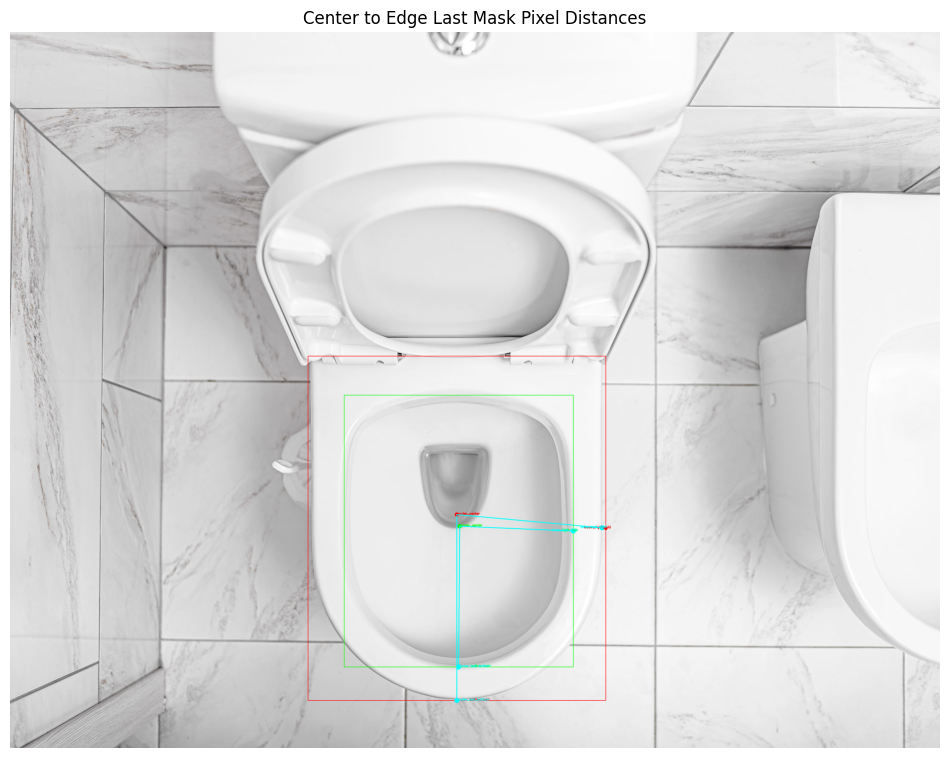

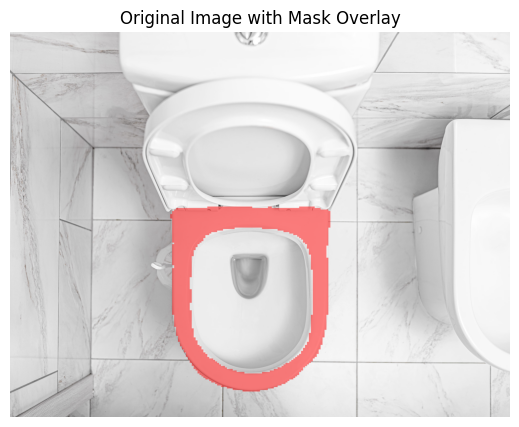

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# img_path = "/content/test57.jpg"
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)
# Predict the mask
mask = predict_mask(image)

# Analyze and draw distances
results = analyze_rect_and_extend(image, mask)

# --- Display mask overlay on original image ---
# Create red mask overlay with transparency
red_mask = np.zeros_like(image)
red_mask[:, :, 0] = 255  # Red channel

alpha = 0.5
# Make mask 3-channel
mask_3ch = np.stack([mask]*3, axis=-1)

# Overlay red mask on original image where mask==1
overlay = image.copy()
overlay = np.where(mask_3ch==1,
                   (image * (1 - alpha) + red_mask * alpha).astype(np.uint8),
                   image)

plt.figure(figsize=(10,5))
plt.imshow(overlay)
plt.axis('off')
plt.title("Original Image with Mask Overlay")
plt.show()


# Fine Tune the Model

In [22]:
import cv2
import numpy as np
import torch

def extract_red_mask(mask_img):
    hsv = cv2.cvtColor(mask_img, cv2.COLOR_RGB2HSV)
    lower_red1 = np.array([0, 150, 150])
    upper_red1 = np.array([5, 255, 255])
    lower_red2 = np.array([175, 150, 150])
    upper_red2 = np.array([180, 255, 255])
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)
    return (red_mask > 0).astype(np.uint8)

def preprocess(image, mask, device, target_size=(256,256)):
    image = cv2.resize(image, target_size)
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image).permute(2,0,1).unsqueeze(0).to(device)
    mask = torch.from_numpy(mask).unsqueeze(0).long().to(device)
    return image, mask

def fine_tune_model(model, image, mask, epochs=5, lr=1e-5):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # For binary segmentation, BCEWithLogitsLoss is typical:
    criterion = torch.nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(image)        # shape [1,1,H,W] or [1,num_classes,H,W]

        # Assuming binary segmentation with 1 output channel
        if output.shape[1] == 1:
            output = output.squeeze(1)  # [1,H,W]
            loss = criterion(output, mask.float())
        else:
            # For multi-class segmentation, use CrossEntropyLoss
            criterion = torch.nn.CrossEntropyLoss()
            loss = criterion(output, mask.squeeze(0))  # mask shape [H,W]

        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")

    print("Fine-tuning completed.")
    return model

# ====== Usage ======

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load your raw image and raw mask image with red
# raw_img_path = "test58.jpg"
print("upload the raw image")
uploaded = files.upload()
raw_img_path = list(uploaded.keys())[0]
# raw_mask_path = "test58_marked.png"
print("upload the masked image")
uploaded = files.upload()
raw_mask_path = list(uploaded.keys())[0]

raw_img = cv2.imread(raw_img_path)
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
raw_mask_img = cv2.imread(raw_mask_path)
raw_mask_img = cv2.cvtColor(raw_mask_img, cv2.COLOR_BGR2RGB)

# Extract binary mask from red regions
binary_mask = extract_red_mask(raw_mask_img)

# Preprocess images to tensor form
image_tensor, mask_tensor = preprocess(raw_img, binary_mask, device)

# Fine-tune the loaded model on this data
model = fine_tune_model(model, image_tensor, mask_tensor, epochs=5, lr=1e-5)


upload the raw image


Saving test53.jpg to test53.jpg
upload the masked image


Saving test53_marked.png to test53_marked.png
Epoch 1/5 - Loss: 0.012950
Epoch 2/5 - Loss: 0.012101
Epoch 3/5 - Loss: 0.011497
Epoch 4/5 - Loss: 0.011106
Epoch 5/5 - Loss: 0.010831
Fine-tuning completed.
